# 深度确定性策略梯度(Deep Deterministic Policy Gradient,DDPG)

In [2]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import collections
import random

In [3]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)
try:
    device = torch.device("cuda:0")
    torch.zeros(1).to(device)
    print(f"成功使用 GPU: {torch.cuda.get_device_name(0)}")
except Exception as e:
    raise RuntimeError(f"无法正常使用 GPU 0: {e} 。")

成功使用 GPU: NVIDIA GeForce RTX 4050 Laptop GPU


## 经验回放

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)     # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), np.array(action), reward, np.array(next_state), done

    def size(self):                # 查看目前buffer中数据的数量
        return len(self.buffer)

## 网络

In [5]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound   # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x)) * self.action_bound


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):           # ⭐️输入状态和动作
        cat = torch.cat([x, a], dim=1) # 拼接状态和动作
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)          # 输出Q值

## DDPG

In [6]:
class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,mean, sigma, actor_lr, critic_lr, tau, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.target_actor.load_state_dict(self.actor.state_dict())

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)    # 没有target_net的优化器
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.gamma = gamma
        self.mean = mean    # 高斯噪声的均值
        self.sigma = sigma  # 高斯噪声的标准差
        self.tau = tau      # 目标网络软更新参数
        self.action_dim = action_dim
        self.device = device
        self.action_bound = action_bound

    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        action = self.actor(state).item()
        action = action + np.random.normal(self.mean,self.sigma,size=self.action_dim)   # 给动作添加噪声，增加探索
        return action
    # 如果传入的state是一维np.array,输出的action是一维np.array

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states, self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)  # 目标q值
        # 更新critic网络
        critic_loss = torch.mean( F.mse_loss(self.critic(states, actions), q_targets) )
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        # 跟新actor网络
        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        # 软更新目标网络
        self.soft_update(self.actor, self.target_actor)
        self.soft_update(self.critic, self.target_critic)

## 训练

### 实例化

In [7]:
minimal_size = 5000
buffer_size = 50000
replay_buffer = ReplayBuffer(buffer_size)

state_dim = env.observation_space.shape[0]
hidden_dim = 64
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
mean = 0
sigma = 0.01  # 高斯噪声标准差
actor_lr = 3e-4
critic_lr = 3e-3
tau = 0.005  # 软更新参数
gamma = 0.99
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound,mean, sigma, actor_lr, critic_lr, tau, gamma, device)

### 训练函数

In [8]:
def train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    for i in range(10):

        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):

                episode_return = 0
                state,info = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    done = terminated or truncated

                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}

                        agent.update(transition_dict)

                return_list.append(episode_return)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list

### 开始训练

In [9]:
batch_size = 64
num_episodes = 300
return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 9: 100%|██████████| 30/30 [00:29<00:00,  1.03it/s, episode=300, return=-161.238]


### 训练结束

In [10]:
torch.save(agent.actor.state_dict(), "ddpg_actor_net_v1.pth")

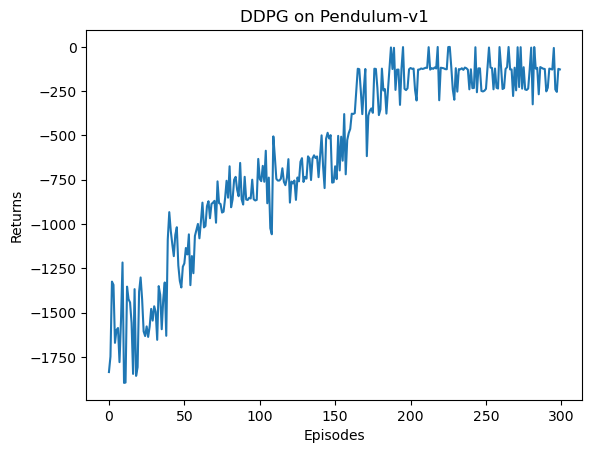

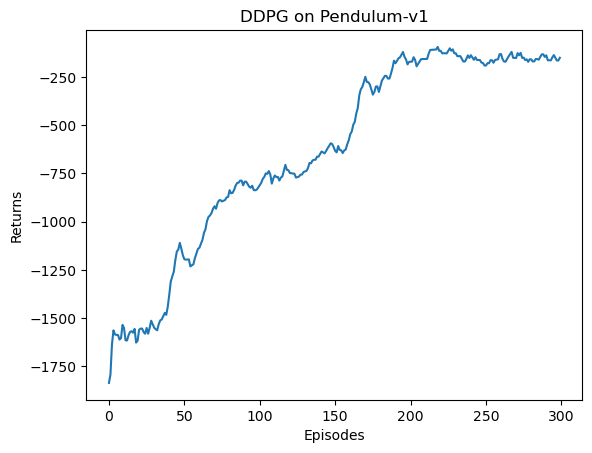

In [11]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

def moving_average(x, window):
    x = np.array(x, dtype=float)
    ma = np.zeros_like(x)  # 存放结果
    for i in range(len(x)):
        start = max(0, i - window + 1)
        end = i + 1
        ma[i] = x[start:end].mean()   # 只用窗口内现有元素求平均
    return ma

mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()